In [ ]:
# Using OceanBase as a vector database for OpenAI embeddings

This notebook guides you step by step on using OceanBase as a vector database for OpenAI embeddings.

This notebook presents an end-to-end process of:
1. Using precomputed embeddings created by OpenAI API.
2. Storing the embeddings in a cloud instance of OceanBase.
3. Converting raw text query to an embedding with OpenAI API.
4. Using OceanBase to perform the nearest neighbour search in the created collection.

### What is OceanBase

[OceanBase](https://www.oceanbase.com/docs/common-oceanbase-database-cn-1000000001573482) is a fully self-developed enterprise-level native distributed database that achieves financial-grade high availability on ordinary hardware. It is the first to create a new standard for automatic lossless disaster recovery of city-level failures in "three locations and five centers", refreshing the TPC-C standard test. The scale of a single cluster exceeds 1,500 nodes, and it has cloud-native, strong consistency, and high compatibility with Oracle/MySQL.



### Deployment options

- Using [OceanBase Vector Database](https://www.oceanbase.com/docs/oceanbase-database-cn). [Click here](https://www.oceanbase.com/docs/common-oceanbase-database-cn-1000000001573530) to fast deploy it.

## Prerequisites

For the purposes of this exercise we need to prepare a couple of things:

1. You have an available cluster instance or shared instance of OceanBase V4.3.3 or above in your environment, and have created a MySQL tenant.
2. You have a project administrator or instance administrator who can read and write instances in the project. If you do not have permissions, you can contact the organization administrator to add permissions.
3. If you do not have an available instance, you can apply for a free trial to experience the OB Cloud database or [deploy the community version](https://www.oceanbase.com/free-trial#trial). Click to view [Free trial rules and activation methods](https://www.oceanbase.com/free-trial#trial).
4. This tutorial takes a shared instance as an example. The operations of a cluster instance and a shared instance are slightly different. If it is a cluster instance, please refer to [Create a tenant](https://www.oceanbase.com/docs/common-oceanbase-cloud-10000000001780087) to complete the tenant creation, and then refer to the following steps.
5. Your environment already has a usable MySQL tenant and MySQL database and account, and the database account has been granted read and write permissions. If you need to create one, see [Create an Account](https://www.oceanbase.com/docs/common-oceanbase-cloud-1000000001018091) and [Create a Database (MySQL Only)](https://www.oceanbase.com/docs/common-oceanbase-cloud-1000000001018092) for details.
6. Install Python 3.9 or above.
7. Install poetry, [pyobvector](https://github.com/oceanbase/pyobvector), and OpenAI SDK.
```shell
pip install poetry
pip install pyobvector
pip install openai
```
>If the run fails, change pip to pip3.
8. Prepare the [OpenAI API key](https://platform.openai.com/api-keys).
9. Make sure you have set the `ob_vector_memory_limit_percentage` parameter in the instance workbench to enable vector retrieval. The recommended setting value is 30. To set this parameter more accurately, refer to [ob_vector_memory_limit_percentage](https://www.oceanbase.com/docs/common-oceanbase-database-cn-1000000001484247) to calculate this value. For the community version, you can use the database connection tool to connect to the database and execute `set ob_vector_memory_limit_percentage = 30` to set it.

## Get the OB database connection string
1. The community version of oceanbse can directly use MySQL CLI as the connection.

2. On the instance list page, click the triangle to the left of the instance name to expand the instance information. Under the target tenant, click **Connect** > **Get connection string**.

3. Select **Use public network** in the pop-up box.

4. On the **Use public IP to connect to the database** page, complete the following settings to generate a connection string:

<table>
<tbody>
<tr>
<th colspan="2">Configuration item</th><th>Description</th>
</tr>
<tr>
<td colspan="2">Add IP address</td>
<td>Click <b>Add</b> to add your egress IP to the whitelist. </td>
</tr>
<tr>
<td colspan="2">Download certificate</td>
<td>(Optional) Click <b>Download certificate</b> to download the CA certificate and complete the authentication. </td>
</tr>
<tr>
<td rowspan="3">Connect to tenant</td>
<td>Database</td>
<td>Click the drop-down box, click <b>+ Create database</b>, and complete the database creation according to the prompts. </td>
</tr>
<tr>
<td>Account</td>
<td>Click the drop-down box, click <b>+ Create account</b>, and complete the account creation according to the prompts. </td>
</tr>
<tr>
<td>Connection method</td>
<td>Select <b>MySQL CLI</b> as the connection method. </td>
</tr>
</tbody>
</table>

<main id="notice" type='alert'>
<h4>Note</h4>
<p>After creating an account, please properly record the password generated when creating the account. </p>
</main>

## Configure OpenAI API key environment variable
1. For Unix-based systems (such as Ubuntu or MacOS), you can run the following command in a terminal:
   ```shell
   export OPENAI_API_KEY='your-api-key'
   ```
3. For Windows, you can use the following command in a command prompt:
   ```shell
   set OPENAI_API_KEY=your-api-key
   ```
5. Make sure to replace `your-api-key` with your actual OpenAI API key.

## Store vector data in OceanBase

In [ ]:
1. Prepare test data:
Download the [CSV file](https://help-static-aliyun-doc.aliyuncs.com/file-manage-files/zh-CN/20240827/srxyhu/fine_food_reviews.csv) with pre-calculated vectorized data. This CSV file contains a dataset of 1,000 food reviews. The last column is the vectorized value, so there is no need to calculate the vector again.
You can also use the following code to recalculate the embedding column (i.e. the vector column) to generate a new CSV file.

In [ ]:
from openai import OpenAI
import pandas as pd
input_datapath = "./fine_food_reviews.csv"
client = OpenAI()
# Here we use the text-embedding-ada-002 embedding model, which can be adjusted as needed
def embedding_text(text, model="text-embedding-ada-002"):
# For methods to create embedding vectors, please refer to: https://community.openai.com/t/embeddings-api-documentation-needs-to-updated/475663
res = client.embeddings.create(input=text, model=model)
return res.data[0].embedding
df = pd.read_csv(input_datapath, index_col=0)
# The actual generation will take several minutes, calling the OpenAI Embedding API line by line
df["embedding"] = df.combined.apply(embedding_text)
output_datapath = './fine_food_reviews_self_embeddings.csv'
df.to_csv(output_datapath)

In [ ]:
2. Run the following script to insert the test data into OceanBase. The script directory needs to be the same as the test data directory.

In [ ]:
import os
import sys
import csv
import json
from pyobvector import *
from sqlalchemy import Column, Integer, String
# Use pyobvector to connect to OB. If there is an @ symbol in the username and password, replace it with %40
client = ObVecClient(uri="host:port", user="username",password="****",db_name="test")
# The test data set prepared in advance has been vectorized and is placed in the same directory as the python script by default. If you re-vectorize it yourself, you need to replace it with the corresponding file
file_name = "fine_food_reviews.csv"
file_path = os.path.join("./", file_name)
# Define columns, and the vectorized columns are placed in the last field
cols = [
Column('id', Integer, primary_key=True, autoincrement=False),
Column('product_id', String(256), nullable=True),
Column('user_id', String(256), nullable=True), Column('score', Integer, nullable=True), Column('summary', String(2048), nullable=True), Column('text', String(8192), nullable=True), Column('combined', String(8192), nullable=True), Column('n_tokens', Integer, nullable=True), Column('embedding', VECTOR(1536)) ] # table name table_name = 'fine_food_reviews' #Create the table if it does not exist if not client.check_table_exists(table_name): client.create_table(table_name,columns=cols) # Create index for vector column client.create_index( table_name=table_name, is_vec_index=True,
index_name='vidx',
column_names=['embedding'],
vidx_params='distance=l2, type=hnsw, lib=vsag',
)
# Open and read CSV file
with open(file_name, mode='r', newline='', encoding='utf-8') as csvfile:
csvreader = csv.reader(csvfile)
# Read the header line
headers = next(csvreader)
print("Headers:", headers)
batch = [] # Store data and insert every 10 rows into the database
for i, row in enumerate(csvreader):
# CSV file has 9 fields: id,product_id,user_id,score,summary,text,combined,n_tokens,embedding
if not row:
break
food_review_line= {'id':row[0],'product_id':row[1],'user_id':row[2],'score':row[3],'summary':row[4],'text':row[5],\
'combined':row[6],'n_tokens':row[7],'embedding':json.loads(row[8])}
batch.append(food_review_line)
# insert every 10 rows
if (i + 1) % 10 == 0:
client.insert(table_name,batch)
batch = [] # clear the cache
# insert the remaining rows (if any)
if batch:
client.insert(table_name,batch)
# check the data in the table to make sure all the data has been inserted
count_sql = f"select count(*) from {table_name};"
cursor = client.perform_raw_text_sql(count_sql)
result = cursor.fetchone()
print(f"Total number of imported data:{result[0]}")

## Query OceanBase data
1. Save the following python script and name it openAIQuery.py.

In [ ]:
import os
import sys
import csv
import json
from pyobvector import *
from sqlalchemy import func
from openai import OpenAI
# Get command line parameters
if len(sys.argv) != 2:
print("Please enter a query statement.")
sys.exit()
queryStatement = sys.argv[1]
# Use pyobvector to connect to OB. If there is an @ symbol in the username and password, replace it with %40
client = ObVecClient(uri="host:port", user="usename",password="****",db_name="test")
openAIclient = OpenAI()
# Define a function to generate text vectors
def generate_embeddings(text, model="text-embedding-ada-002"):
# For the method of creating embedding vectors, please refer to: https://community.openai.com/t/embeddings-api-documentation-needs-to-updated/475663
res = openAIclient.embeddings.create(input=text, model=model) return res.data[0].embedding def query_ob(query, tableName, vector_name="embedding", top_k=1): embedding = generate_embeddings(query) # Perform an approximate nearest neighbor search res = client.ann_search( table_name=tableName, vec_data=embedding, vec_column_name=vector_name, distance_func=func.l2_distance, topk=top_k, output_column_names=['combined'] ) for row in res: print(str(row[0]).replace("Title: ", "").replace("; Content: ", ": ")) # table name table_name = 'fine_food_reviews' query_ob(queryStatement,table_name,'embedding',1)

In [ ]:
2. Input the question and output the relevant answer.

In [ ]:
python3 openAIQuery.py 'pet food'

Return result:\
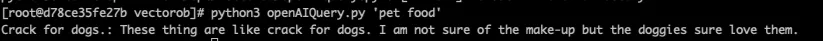

In [ ]:
python3 openAIQuery.py 'delicious beans'

Return result:\
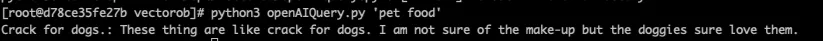

Create table structure in OB:\
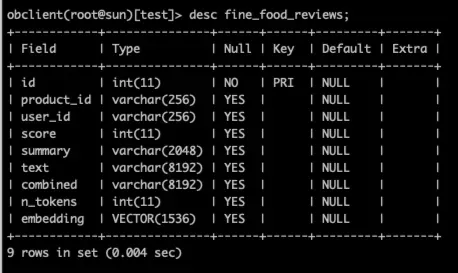

Data example in the database:\
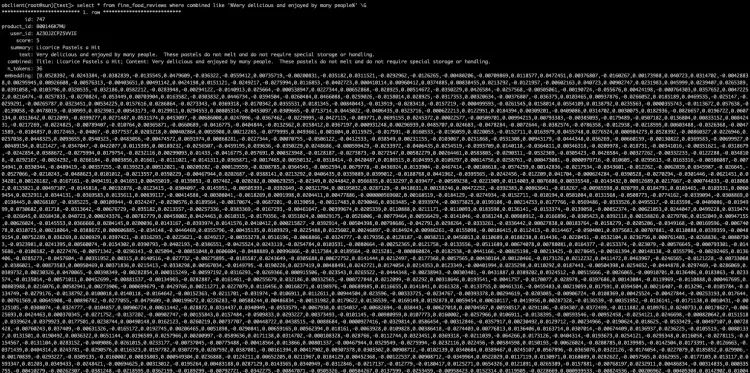